In [1]:
import praw
import matplotlib.pyplot as plt
import numpy as np
from psaw import PushshiftAPI
import nltk
import datetime as dt
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

# Initialize API wrapper

In [2]:
reddit = praw.Reddit(client_id='',
                      client_secret='',
                      user_agent='test')
print(reddit.read_only) 

api = PushshiftAPI(reddit)

True


# Grab data from subreddit

In [3]:
start_epoch = int(dt.datetime(2018, 11, 1).timestamp())
end_epoch = int(dt.datetime(2019, 2, 24).timestamp())

sub_psaw = list(api.search_submissions(before=end_epoch, after=start_epoch,
                            subreddit='kanye',
                            limit=40000))

In [4]:
len(sub_psaw)

19665

#  Clean and explore data,  construct features

In [5]:
# for sub in sub_psaw:
#     print(sub.selftext)

In [6]:
# Clean out posts that have been removed/deleted
cleaned_inds = [('[removed]' not in sub.selftext) and ('[deleted]' not in sub.selftext) for sub in sub_psaw]
sub_psaw = np.asarray(sub_psaw)

In [7]:
len(sub_psaw[cleaned_inds])

14936

In [8]:
upvote_ratios = [sub.upvote_ratio for sub in sub_psaw[cleaned_inds]]
score = [sub.score for sub in sub_psaw[cleaned_inds]]

In [9]:
def averaged_profile(r, data, binwidth):
    r = np.asarray(r) / binwidth
    r = r.astype(np.int32)
    data = np.asarray(data)
    av = np.bincount(r, data) / np.bincount(r)
    sigma = np.sqrt((np.bincount(r, data*data) / np.bincount(r))-(av*av))
    return  av, sigma

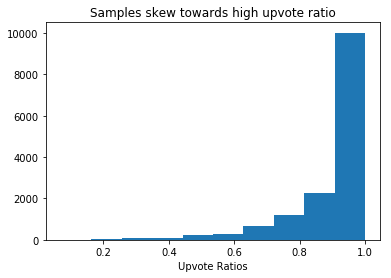

In [10]:
plt.hist(upvote_ratios)
plt.xlabel('Upvote Ratios')
plt.title('Samples skew towards high upvote ratio')
plt.show()

/Users/vish/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/vish/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


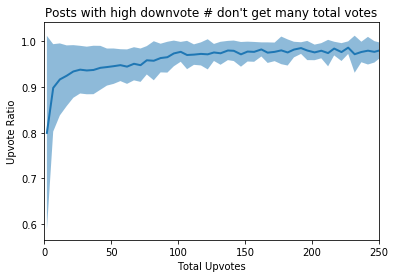

In [29]:
av_ur, sigma_ur = averaged_profile(score, upvote_ratios, 5)
av_s, sigma_s = averaged_profile(score, score, 5)
plt.fill_between(av_s, av_ur+sigma_ur, av_ur-sigma_ur, alpha=.5)
plt.plot(av_s, av_ur, lw=2)
plt.xlim(0,250)
plt.xlabel('Total Upvotes')
plt.ylabel('Upvote Ratio')
plt.title('Posts with high downvote # don\'t get many total votes')
plt.show()
plt.close()

In [12]:
titles_raw = [sub.title for sub in sub_psaw[cleaned_inds]]
target = [int(sub.upvote_ratio*10) for sub in sub_psaw[cleaned_inds]]
# target = [sub.upvote_ratio>.8 for sub in sub_psaw[cleaned_inds]]

train_raw = titles_raw[:int(len(titles_raw)//1.5)]
test_raw = titles_raw[int(len(titles_raw)//1.5):]

target_train = target[:int(len(titles_raw)//1.5)]
target_test = target[int(len(titles_raw)//1.5):]


In [13]:
def text_process(text):
    # Remove Punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    # Remove Stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [14]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

tf_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents = 'unicode', 
                                analyzer=text_process, 
                                lowercase = True) 

# Construct pipeline and fit

In [15]:
text_clf = Pipeline([('vect', tf_vectorizer),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

In [16]:
text_clf = text_clf.fit(np.asarray(train_raw), np.asarray(target_train))

In [21]:
predicted = text_clf.predict(test_raw)
tol0 = np.mean(np.abs(predicted - target_test) < 1)
print('0-tolerance accuracy=%f'%tol0)
tol1 = np.mean(np.abs(predicted - target_test) < 2)
print('1-tolerance accuracy=%f'%tol1)
tol2 = np.mean(np.abs(predicted - target_test) < 3)
print('2-tolerance accuracy=%f'%tol2)

0-tolerance accuracy=0.453906
1-tolerance accuracy=0.833300
2-tolerance accuracy=0.906206


Mean Deviance = 0.891143


Text(0.5,0,'Deviation from Prediction')

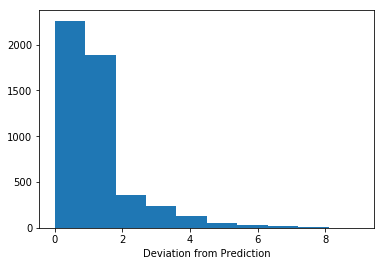

In [23]:
print('Mean Deviance = %f'%np.mean(abs(target_test-predicted)))
_ = plt.hist(abs(target_test-predicted))
plt.xlabel('Deviation from Prediction')

### Try changing classifier:

In [24]:
text_clf_svm = Pipeline([('vect', tf_vectorizer),
                     ('tfidf', TfidfTransformer()),
                     ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, max_iter=5, random_state=42)),
])

_ = text_clf_svm.fit(train_raw, target_train)

In [25]:
predicted_svm = text_clf_svm.predict(test_raw)
tol0 = np.mean(np.abs(predicted_svm - target_test) < 1)
print('0-tolerance accuracy=%f'%tol0)
tol1 = np.mean(np.abs(predicted_svm - target_test) < 2)
print('1-tolerance accuracy=%f'%tol1)
tol2 = np.mean(np.abs(predicted_svm - target_test) < 3)
print('2-tolerance accuracy=%f'%tol2)

0-tolerance accuracy=0.430207
1-tolerance accuracy=0.796345
2-tolerance accuracy=0.890339


Mean Deviance = 0.984736


Text(0.5,0,'Deviation from Prediction')

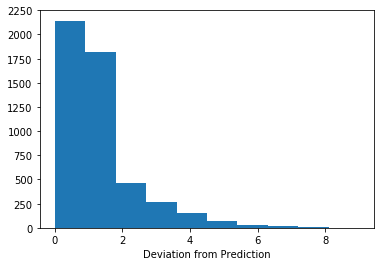

In [26]:
print('Mean Deviance = %f'%np.mean(abs(target_test-predicted_svm)))
_ = plt.hist(abs(target_test-predicted_svm))
plt.xlabel('Deviation from Prediction')

### Finally, be more robust with gridsearch:

In [27]:
parameters = {'vect__ngram_range': [(1, 1), (1, 3)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train_raw, target_train)

print(gs_clf.best_score_)
print(gs_clf.best_params_)

/Users/vish/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.39811188108868134
{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}


In [28]:
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 3)],
              'tfidf__use_idf': (True, False),
              'clf-svm__alpha': (1e-2, 1e-3),
}
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(train_raw, target_train)
print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

/Users/vish/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.43035050718087775
{'clf-svm__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
